In [1]:
from make_ewma_features_df import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Fitting model

In [5]:
ewma_merge_lag = make_ewma_features_df(25, 0.4).dropna()

In [ ]:
model_dict = {}
for pos in ['FWD', 'MID', 'DEF', 'GK']:
    ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
    X = ewma_merge_lag_pos[[
        'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']]

    y = ewma_merge_lag_pos['nw_total_points']

    model = LinearRegression()
    model.fit(X, y)

    model_dict[pos] = model

# Testing on last season

In [13]:
gw5_mid = ewma_merge_lag.query('gw==5 and position=="MID"').set_index(['full_name', 'gw'])

In [16]:
mid_pred = model_dict['MID'].predict(gw5_mid[['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
        'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
        'minutes', 'ewma_total_points', 'ewma_team_goals',
        'ewma_nw_opponent_goals']])

In [17]:
gw5_mid['pred'] = mid_pred

In [26]:
gw5_mid.sort_values('pred', ascending=False)[['total_points', 'pred']]

,,total_points,pred
full_name,gw,,
mohamed_salah,5,6,6.873085
luis_diaz,5,16,5.256267
brennan_johnson,5,7,4.724197
son_heung_min,5,10,4.598913
james_maddison,5,12,4.589784
...,...,...,...
lewis_dobbin,5,0,0.071000
kadan_young,5,0,0.071000
enzo_barrenechea,5,0,0.071000


In [24]:
gw5_mid.loc['leandro_trossard']

,total_points,position,team,opponent_team,assists,bonus,bps,clean_sheets,goals_conceded,goals_scored,...,threat,ict_index,minutes,ewma_total_points,opponent_team_name,ewma_team_goals,nw_total_points,nw_opponent,ewma_nw_opponent_goals,pred
gw,,,,,,,,,,,,,,,,,,,,,
5,-2,MID,Arsenal,13,0.0,0.0864,3.1232,0.24,0.944,0.0864,...,8.0704,2.1096,51.568,0.7984,Man City,1.616,12.0,Leicester,2.3168,1.16786


<Axes: xlabel='total_points', ylabel='pred'>

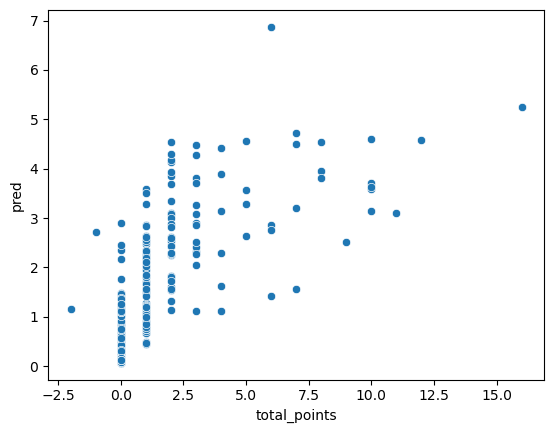

In [22]:
sns.scatterplot(data=gw5_mid, x='total_points', y='pred')

# Applying to this season's data

In [30]:
import requests, json

In [34]:
import time
def get_entry_gws_data(entry_id,num_gws,start_gw=1):
    """ Retrieve the gw-by-gw data for a specific entry/team

    Args:
        entry_id (int) : ID of the team whose data is to be retrieved
    """
    base_url = "https://fantasy.premierleague.com/api/entry/"
    gw_data = []
    for i in range(start_gw, num_gws+1):
        full_url = base_url + str(entry_id) + "/event/" + str(i) + "/picks/"
        response = ''
        while response == '':
            try:
                response = requests.get(full_url)
            except:
                time.sleep(5)
        if response.status_code != 200:
            raise Exception("Response was code " + str(response.status_code))
        data = json.loads(response.text)
        gw_data += [data]
    return gw_data

In [35]:
event_id = 1
url = f'https://fantasy.premierleague.com/api/event/{event_id}/live/'

response = requests.get(url)
if response.status_code != 200:
    raise Exception("Response was code " + str(response.status_code))
gw1 = json.loads(response.text)

In [31]:
league_url = 'https://draft.premierleague.com/api/league/19188/element-status'
r = requests.get(league_url).json()
ownership_df = pd.json_normalize(r['element_status'])

,element,in_accepted_trade,owner,status
0,170,False,NaN,a
1,434,False,NaN,a
2,218,False,NaN,a
3,138,False,NaN,a
4,178,False,NaN,a
...,...,...,...,...
735,441,False,87737.0,o
736,682,False,94654.0,o
737,715,False,93330.0,o
738,718,False,85076.0,o
